In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
import os 
os.chdir("/content/drive/MyDrive")
Dataset='Dataset'
Data_Dir=os.listdir(Dataset)
print(Data_Dir)

['with_mask', 'without_mask']


In [9]:
import cv2
import numpy as np
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
img_rows, img_cols=112,112
images=[]
labels=[]
for category in Data_Dir:
  folder_path =os.path.join(Dataset,category)
  for img in os.listdir(folder_path):
    img_path=os.path.join(folder_path,img)
    img=cv2.imread(img_path)
    try:

      #Coverting the image into gray scale
      grayscale_img=cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

      #resizing the gray scaled image into size 56x56 in order to keep size the images consistent 
      resized_img=cv2.resize(grayscale_img, (img_rows, img_cols))
      images.append(resized_img)
      labels.append(category)

    #Exception Handling in case any error occurs
    except Exception as e:
      print('Exception:', e)

images=np.array(images)/255.0
images=np.reshape (images, (images.shape[0], img_rows, img_cols,1))
#Perform one hot encoding on the labels since the label are in textual form
lb=LabelBinarizer()
labels=lb.fit_transform(labels)
labels = to_categorical(labels)
labels=np.array(labels)

train_X,test_X,train_y,test_y=train_test_split(images,labels,test_size=0.25,random_state=0)

In [13]:
#Import Necessary Keras Libraries 
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout
from keras.layers import Conv2D, MaxPooling2D

#Define model paranters

num_classes=2
batch_size=32

#Build CNN model using Sequential API 
model=Sequential()

#First layer group containing Convolution, Relu and MaxPooling layers 
model.add(Conv2D (64, (3,3), input_shape=(img_rows, img_cols, 1)))
model.add(Activation ('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

#Second layer group containing Convolution, Relu and MaxPooling layers

model.add(Conv2D(128, (3,3)))
model.add (Activation('relu'))
model.add (MaxPooling2D(pool_size=(2,2)))

#Flatten and droput layer to stack the output convolutions above as well as cater overfitting
model.add(Flatten())
model.add(Dropout(0.5))

#Softmax Classifier
model.add(Dense(64,activation='relu'))
model.add(Dense(num_classes, activation='softmax'))
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 110, 110, 64)      640       
_________________________________________________________________
activation_2 (Activation)    (None, 110, 110, 64)      0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 55, 55, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 53, 53, 128)       73856     
_________________________________________________________________
activation_3 (Activation)    (None, 53, 53, 128)       0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 26, 26, 128)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 86528)            

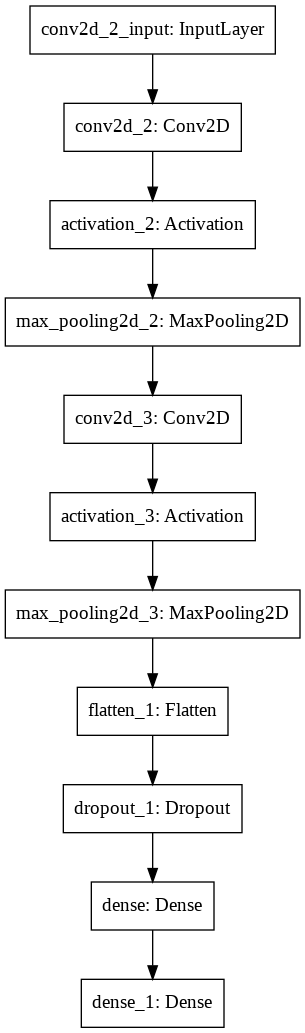

In [14]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='face_mask_detection_architecture.png')

In [18]:
from tensorflow.keras.optimizers import Adam
epochs=50
model.compile(loss='categorical_crossentropy',optimizer=Adam(learning_rate=0.001),metrics=['accuracy'])

fitted_model=model.fit(
  train_X,
  train_y,
  epochs=epochs,
  validation_split=0.25)

Epoch 1/50
25/25 [==============================] - 2s 72ms/step - loss: 0.7904 - accuracy: 0.5052 - val_loss: 0.6928 - val_accuracy: 0.5775
Epoch 2/50
25/25 [==============================] - 1s 51ms/step - loss: 0.6846 - accuracy: 0.5633 - val_loss: 0.6512 - val_accuracy: 0.7442
Epoch 3/50
25/25 [==============================] - 1s 58ms/step - loss: 0.6157 - accuracy: 0.6602 - val_loss: 0.5392 - val_accuracy: 0.7364
Epoch 4/50
25/25 [==============================] - 1s 51ms/step - loss: 0.4613 - accuracy: 0.7739 - val_loss: 0.3868 - val_accuracy: 0.8411
Epoch 5/50
25/25 [==============================] - 1s 58ms/step - loss: 0.3191 - accuracy: 0.8695 - val_loss: 0.5418 - val_accuracy: 0.7597
Epoch 6/50
25/25 [==============================] - 1s 51ms/step - loss: 0.3072 - accuracy: 0.8682 - val_loss: 0.2795 - val_accuracy: 0.8798
Epoch 7/50
25/25 [==============================] - 1s 52ms/step - loss: 0.1895 - accuracy: 0.9406 - val_loss: 0.2144 - val_accuracy: 0.9225
Epoch 8/50
25

# Plot the training Loss and Accuracy

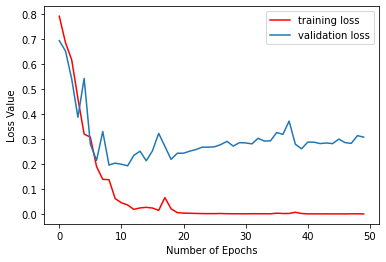

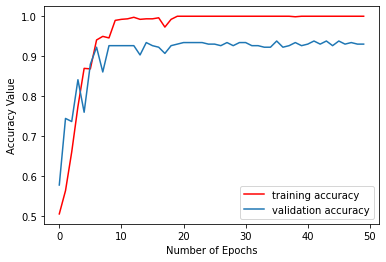

In [22]:
from matplotlib import pyplot as plt

#Plot Training and validation Loss
plt.plot(fitted_model.history['loss'], 'r',label= "training loss")
plt.plot(fitted_model.history["val_loss"], label='validation loss')
plt.xlabel('Number of Epochs') 
plt.ylabel('Loss Value')
plt.legend()
plt.show()

#Plot Training and Validation Accuracy 
plt.plot(fitted_model.history['accuracy'] , 'r',label="training accuracy")
plt.plot(fitted_model.history['val_accuracy' ], label= "validation accuracy")
plt.xlabel('Number of Epochs') 
plt.ylabel('Accuracy Value')
plt.legend() 
plt.show()

In [23]:
#Saving the model
model.save('face_mask_detection_alert_system.h5')